In [1]:
import h5py
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc
import scipy
from sklearn.metrics import mean_squared_error
os.environ['CUDA_VISIBLE_DEVICES']='2'
TASK_N = 1

In [2]:
def residual_block(input_layer, filter_size, activation='relu', dilated=False):
    if dilated:
        factor = [2, 4]
    else:
        factor = [1]
    num_filters = input_layer.shape.as_list()[-1]  

    nn = keras.layers.Conv1D(filters=num_filters,
                                    kernel_size=filter_size,
                                    activation=None,
                                    use_bias=False,
                                    padding='same',
                                    dilation_rate=1,
                                    )(input_layer) 
    nn = keras.layers.BatchNormalization()(nn)
    for f in factor:
        nn = keras.layers.Activation('relu')(nn)
        nn = keras.layers.Dropout(0.1)(nn)
        nn = keras.layers.Conv1D(filters=num_filters,
                                        kernel_size=filter_size,
                                        strides=1,
                                        activation=None,
                                        use_bias=False, 
                                        padding='same',
                                        dilation_rate=f,
                                        )(nn) 
        nn = keras.layers.BatchNormalization()(nn)
    nn = keras.layers.add([input_layer, nn])
    return keras.layers.Activation(activation)(nn)
            
def model_2CNN(input_shape,output_shape,norm = False):

  l2 = keras.regularizers.l2(1e-8)
  # input layer
  inputs = keras.layers.Input(shape=input_shape)

  #optional layer norm
  if norm == True:
    nn = keras.layers.LayerNormalization()(inputs)
  else:
    nn = inputs

  # layer 1 - convolution
  nn = keras.layers.Conv1D(filters=96,
                              kernel_size=19,
                              strides=1,
                              activation=None,
                              use_bias=False,
                              padding='same',
                              kernel_regularizer=l2, 
                              )(nn)        
  nn = keras.layers.BatchNormalization()(nn)
  nn = keras.layers.Activation('exponential')(nn)
  nn = keras.layers.Dropout(0.1)(nn)
  
  nn = residual_block(nn, filter_size=3, dilated=True)
  nn = keras.layers.Activation('relu')(nn)

  #change parameter
  nn = keras.layers.MaxPool1D(pool_size=10)(nn)
  nn = keras.layers.Dropout(0.1)(nn)
  
  # layer 2 - convolution
  nn = keras.layers.Conv1D(filters=128,
                              kernel_size=7,
                              strides=1,
                              activation=None,
                              use_bias=False,
                              padding='same',
                              kernel_regularizer=l2, 
                              )(nn)        
  nn = keras.layers.BatchNormalization()(nn)
  nn = keras.layers.Activation('relu')(nn)
  nn = keras.layers.GlobalAveragePooling1D()(nn)
  nn = keras.layers.Dropout(0.1)(nn)

  # layer 3 - Fully-connected 
  nn = keras.layers.Flatten()(nn)
  nn = keras.layers.Dense(128,
                          activation='relu',
                          use_bias=True
                          )(nn)      
  nn = keras.layers.Dropout(0.5)(nn)

  # Output layer
  outputs = keras.layers.Dense(output_shape, activation='linear', use_bias=True)(nn)
  model = keras.Model(inputs=inputs, outputs=outputs)
  return model

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10, 
                                            verbose=1, 
                                            mode='min', 
                                            restore_best_weights=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                              factor=0.2,
                                              patience=3, 
                                              min_lr=1e-7,
                                              mode='min',
                                              verbose=1) 

# Use self-supervised Embeddings to train model

In [15]:
f = h5py.File('/home/amber/multitask_RNA/data/rna_stable/gpn_human_embed.h5','r')
x_train = f['X_train'][()]
y_train = f['Y_train'][()]
x_test = f['X_test'][()]
y_test = f['Y_test'][()]
x_valid = f['X_valid'][()]
y_valid = f['Y_valid'][()]

In [16]:
model = model_2CNN(x_train.shape[1:],TASK_N,norm=True)
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
loss = keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)


Epoch 10: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Epoch 15: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.

Epoch 18: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.

Epoch 21: ReduceLROnPlateau reducing learning rate to 1.600000018697756e-07.
Restoring model weights from the end of the best epoch: 12.
Epoch 22: early stopping


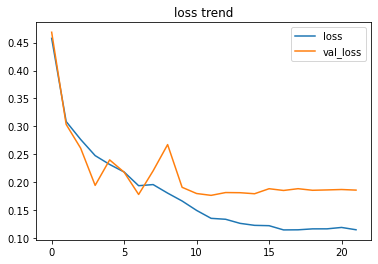

In [17]:
# train model
log_train = np.log(y_train[:,:TASK_N]+1)
log_valid = np.log(y_valid[:,:TASK_N]+1)
history = model.fit(x_train, log_train, 
                     epochs=200,
                     batch_size=64,
                     verbose = 0, 
                     shuffle=True,
                     validation_data=(x_valid, log_valid), 
                     callbacks=[es_callback, reduce_lr])
    
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('loss trend')
plt.legend()

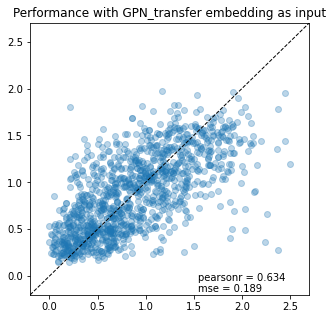

In [18]:
y_pred = model.predict(x_test)
y_label = np.log(y_test+1)
#y_label = np.expand_dims(y_test2[:,2], axis=1)
#y_label = (y_label - np.mean(y_label))/np.std(y_label)
fig, axs = plt.subplots(1,TASK_N,figsize=(5*TASK_N,5))
for i in range(TASK_N):
    pearsonr = scipy.stats.pearsonr(y_label[:,i], y_pred[:,i])
    mse = mean_squared_error(y_label[:,i], y_pred[:,i])

    if TASK_N == 1:
        sub_ax = axs
    else:
        sub_ax = axs[i]

    sub_ax.scatter(y_label[:,i], y_pred[:,i], alpha=0.3)
    sub_ax.annotate("pearsonr = {:.3f}".format(pearsonr[0]),xy=(0.6, 0.05), xycoords="axes fraction")
    sub_ax.annotate("mse = {:.3f}".format(mse),xy=(0.6, 0.01), xycoords="axes fraction")

    MIN = -.2
    MAX = 2.7
    plt.xlim([MIN, MAX])
    plt.ylim([MIN, MAX])
    plt.title('Performance with GPN_transfer embedding as input')
    sub_ax.plot([MIN, MAX], [MIN, MAX], linestyle='--', color='k', lw=1, scalex=False, scaley=False)

# Use original dataset to train same model

In [7]:
f = h5py.File('../../data/rna_stable/insert_dataset.h5','r')
x_train = f['X_train'][()]
y_train = f['Y_train'][()]
x_test = f['X_test'][()]
y_test = f['Y_test'][()]
x_valid = f['X_valid'][()]
y_valid = f['Y_valid'][()]

In [8]:
model = model_2CNN(x_train.shape[1:],TASK_N)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)


Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 8: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 11: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 20: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.

Epoch 23: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.

Epoch 26: ReduceLROnPlateau reducing learning rate to 1e-07.
Restoring model weights from the end of the best epoch: 17.
Epoch 27: early stopping


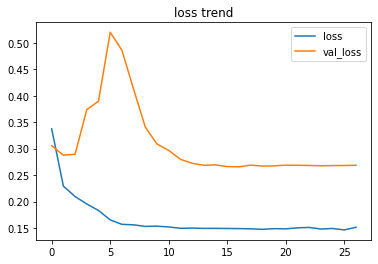

In [9]:
# train model
log_train = np.log(y_train[:,:TASK_N]+1)
log_valid = np.log(y_valid[:,:TASK_N]+1)
history = model.fit(x_train, log_train, 
                     epochs=200,
                     batch_size=128, 
                     shuffle=True,
                     verbose = 0,
                     validation_data=(x_valid, log_valid), 
                     callbacks=[es_callback, reduce_lr])
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('loss trend')
plt.legend()


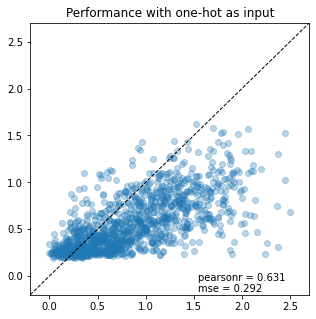

In [10]:
y_pred = model.predict(x_test)
y_label = np.log(y_test+1)
#y_label = np.expand_dims(y_test2[:,2], axis=1)
#y_label = (y_label - np.mean(y_label))/np.std(y_label)
fig, axs = plt.subplots(1,TASK_N,figsize=(5*TASK_N,5))
for i in range(TASK_N):
    pearsonr = scipy.stats.pearsonr(y_label[:,i], y_pred[:,i])
    mse = mean_squared_error(y_label[:,i], y_pred[:,i])

    if TASK_N == 1:
        sub_ax = axs
    else:
        sub_ax = axs[i]

    sub_ax.scatter(y_label[:,i], y_pred[:,i], alpha=0.3)
    sub_ax.annotate("pearsonr = {:.3f}".format(pearsonr[0]),xy=(0.6, 0.05), xycoords="axes fraction")
    sub_ax.annotate("mse = {:.3f}".format(mse),xy=(0.6, 0.01), xycoords="axes fraction")

    MIN = -.2
    MAX = 2.7
    plt.xlim([MIN, MAX])
    plt.ylim([MIN, MAX])
    plt.title('Performance with one-hot as input')
    sub_ax.plot([MIN, MAX], [MIN, MAX], linestyle='--', color='k', lw=1, scalex=False, scaley=False)